In [33]:
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import copy
import pkg_resources
from numpy import ndarray
from numpy.typing import NDArray
from dataclasses import dataclass
from typing import Callable, List, Optional


In [34]:
from trachoma.trachoma_functions_age import *
import multiprocessing
from joblib import Parallel, delayed
import pkg_resources
num_cores = multiprocessing.cpu_count()

#############################################################################################################################
#############################################################################################################################

# initialize parameters, sim_params, and demography

params = {'N': 10000,
          'av_I_duration' : 2,
          'av_ID_duration':200/7,
          'inf_red':0.45,
          'min_ID':11, #Parameters relating to duration of infection period, including ID period
          'av_D_duration':300/7,
          'min_D':1, #Parameters relating to duration of disease period
          'v_1':1,
          'v_2':2.6,
          'phi':1.4,
          'epsilon':0.5,#Parameters relating to lambda function- calculating force of infection
          #Parameters relating to MDA
          'MDA_Cov':0.8,
          'MDA_Eff': 0.85, # Efficacy of treatment
          'rho':0.3,
          'nweeks_year':52,
          'babiesMaxAge':0.5, #Note this is years, need to check it converts to weeks later
          'youngChildMaxAge':9,#Note this is years, need to check it converts to weeks later
          'olderChildMaxAge':15, #Note this is years, need to check it converts to weeks later
          'b1':1,#this relates to bacterial load function
          'ep2':0.114,
          'n_inf_sev':38,
          'TestSensitivity': 0.96,
          'TestSpecificity': 0.965,
          'SecularTrendIndicator': 0,
          'SecularTrendYearlyBetaDecrease': 0.01,
          'vacc_prob_block_transmission':  0.5, 
          'vacc_reduce_bacterial_load': 0.5, 
          'vacc_reduce_duration': 0.5,
          'vacc_coverage': 0,  
          'vacc_waning_length': 52 * 5}


burnin = 100*52
timesim = burnin + 21*52 # was 21

sim_params = {'timesim': timesim, 
              'burnin': burnin,
              'N_MDA':5, # irrelevant due to input method
              'n_sim':100}


demog = {'tau': 0.0004807692, 
         'max_age': 3120,
         'mean_age': 1040}



previous_rounds = 0


Start_date = date(2010,1, 1)
End_date = date(2030,12,31)


## Modifying Matt's updated run folder to include the version of sim_Ind_MDA which includes vaccination. Need to update/match inputs for SimulationFunction.

In [35]:
def seed_to_state(seed):
    np.random.seed(seed)
    return np.random.get_state()

outputYear = range(2019, 2041) # CHECK this, was 2019 to 2041
outputTimes = getOutputTimes(outputYear)
outputTimes = get_Intervention_times(outputTimes, Start_date, sim_params['burnin'])

# this is essentially the same as the original version of the Trachoma_Simulation function

def SimulationFunction(params, sim_params, demog, MDA_times, MDAData, vacc_times, VaccData, seed_bump, beta):

    # Longitudinal simulations:

    # Setting beta; the higher this is the higher the prevalence. 0.12 has prevalence around 20%
    #bet = np.random.uniform(size=sim_params['n_sim'], low=0.1, high=0.12)
    bet = np.ones(sim_params['n_sim']) * beta
    # Run multiple simulations
    def multiple_simulations(i):
        seed = i * seed_bump

        # Generate some random numbers
        np.random.seed(seed)
# we generate a numpy state for each simulation by saving a state. If the seed is set above, this will be consistent from run to run
        numpy_states = list(map(lambda s: seed_to_state(s), np.random.randint(2^32, size=1)))
        vals = Set_inits(params=params, demog=demog, sim_params = sim_params, MDAData=MDAData, numpy_state = numpy_states[0])    # Set initial conditions
        vals = Seed_infection(params=params, vals=vals) # Seed infection
        
        # vals = Check_and_init_MDA_and_survey_counts(vals, numpy_states[0])
        
        vals = Check_and_init_vaccination_state(params,vals)
        
        vals = Check_and_init_MDA_treatment_state(params, vals, MDAData, numpy_state=numpy_states[0])
        
        out, results = sim_Ind_MDA_Include_Survey(params, vals, timesim, burnin, demog, bet[i], MDA_times, MDAData, vacc_times, VaccData, outputTimes, doSurvey = False, doIHMEOutput = False, numpy_state = numpy_states[0])
        return out

    data_store_all_sim = Parallel(n_jobs=num_cores)(delayed(multiple_simulations)(i) for i in range(sim_params['n_sim']))

    return data_store_all_sim




# analyse the runs of the simulations
# we return some aggregated results (along with the raw data)
def analyseResults(data, sim_params):

    True_Prev_Infection_children_1_9 = np.zeros(shape=(sim_params['timesim'] , sim_params['n_sim']))
    True_Prev_Disease_children_1_9 = np.zeros(shape=(sim_params['timesim'] , sim_params['n_sim']))
    #True_Prev_Disease = np.zeros(shape=(sim_params['timesim'] , sim_params['n_sim']))
    #True_Prev_Infection = np.zeros(shape=(sim_params['timesim'] , sim_params['n_sim']))
    Time = np.arange(sim_params['timesim'] )
    
    # same as above but for INDIVIDUAL ages up to 10
    prev_diseases_ages = [np.zeros(shape=(sim_params['timesim'] , sim_params['n_sim'])) for _ in range(10)]
    prev_infection_ages = [np.zeros(shape=(sim_params['timesim'] , sim_params['n_sim'])) for _ in range(10)]
    
    # we will store the age, infection, and bacteria distributions at times specified by dh_dates
    dh_dates = [5667, 5824, 5928, 6085]
    ages = {}
    inf_counts = {}
    bacteria = {}
    for date in dh_dates:
        ages[str(date)] = []
        inf_counts[str(date)] = []
        bacteria[str(date)] = []
        
    # store lambda, new infections, and proportion newly infected for each group each week
    infection_forces = [np.zeros(shape=(sim_params['timesim'] , sim_params['n_sim'])) for _ in range(3)]
    new_infections = [np.zeros(shape=(sim_params['timesim'] , sim_params['n_sim'])) for _ in range(3)] # 3 = num of groups
    new_props = [np.zeros(shape=(sim_params['timesim'] , sim_params['n_sim'])) for _ in range(3)]
    
    for i in range(sim_params['n_sim']):

        #True_Prev_Disease[:, i] = data[i]['True_Prev_Disease'][0: sim_params['timesim']]
        #True_Prev_Infection[:, i] = data[i]['True_Prev_Infection'][0: sim_params['timesim']]
        True_Prev_Infection_children_1_9[:, i] = data[i]['True_Prev_Infection_children_1_9'][0: sim_params['timesim']]
        True_Prev_Disease_children_1_9[:, i] = data[i]['True_Prev_Disease_children_1_9'][0: sim_params['timesim']]
        
        for j in range(10):
            prev_diseases_ages[j][:, i] = data[i]['age_prevalences'][j][0: sim_params['timesim']]
            prev_infection_ages[j][:, i] = data[i]['age_infections'][j][0: sim_params['timesim']]
        
        # essentially transfer all the ages from each run into the corresponding time of 'ages'. same for infs and bact
        for date in dh_dates:
            for age in data[i]['ages'][str(date)]:
                ages[str(date)].append(age)
                
            for infs in data[i]['inf_counts'][str(date)]:
                inf_counts[str(date)].append(infs)
                
            for bact in data[i]['bacteria'][str(date)]:
                bacteria[str(date)].append(bact)
                
        for g in range(3):
            infection_forces[g][:, i] = data[i]['forces'][g][0: sim_params['timesim']]
            new_infections[g][:, i] = data[i]['new_infs'][g][0: sim_params['timesim']]
            new_props[g][:, i] = data[i]['new_props'][g][0: sim_params['timesim']]
        
    
    results = pd.DataFrame({'Time': Time / 52,
                            'Mean_Disease_Children': np.mean(True_Prev_Disease_children_1_9, axis=1),
                            'Mean_Infection_Children': np.mean(True_Prev_Infection_children_1_9, axis=1),
                            #'Mean_Disease_All': np.mean(True_Prev_Disease, axis=1),
                            #'Mean_Infection_All': np.mean(True_Prev_Infection, axis=1),
                            'Median_Disease_Children': np.median(True_Prev_Disease_children_1_9, axis=1),
                            'Median_Infection_Children': np.median(True_Prev_Infection_children_1_9, axis=1),
                            #'Median_Disease_All': np.median(True_Prev_Disease, axis=1),
                            #'Median_Infection_All': np.median(True_Prev_Infection, axis=1)
                            'Median_Dis_0': np.median(prev_diseases_ages[0], axis=1),
                            'Median_Inf_0': np.median(prev_infection_ages[0], axis=1),
                            'Median_Dis_1': np.median(prev_diseases_ages[1], axis=1),
                            'Median_Inf_1': np.median(prev_infection_ages[1], axis=1),
                            'Median_Dis_2': np.median(prev_diseases_ages[2], axis=1),
                            'Median_Inf_2': np.median(prev_infection_ages[2], axis=1),
                            'Median_Dis_3': np.median(prev_diseases_ages[3], axis=1),
                            'Median_Inf_3': np.median(prev_infection_ages[3], axis=1),
                            'Median_Dis_4': np.median(prev_diseases_ages[4], axis=1),
                            'Median_Inf_4': np.median(prev_infection_ages[4], axis=1),
                            'Median_Dis_5': np.median(prev_diseases_ages[5], axis=1),
                            'Median_Inf_5': np.median(prev_infection_ages[5], axis=1),
                            'Median_Dis_6': np.median(prev_diseases_ages[6], axis=1),
                            'Median_Inf_6': np.median(prev_infection_ages[6], axis=1),
                            'Median_Dis_7': np.median(prev_diseases_ages[7], axis=1),
                            'Median_Inf_7': np.median(prev_infection_ages[7], axis=1),
                            'Median_Dis_8': np.median(prev_diseases_ages[8], axis=1),
                            'Median_Inf_8': np.median(prev_infection_ages[8], axis=1),
                            'Median_Dis_9': np.median(prev_diseases_ages[9], axis=1),
                            'Median_Inf_9': np.median(prev_infection_ages[9], axis=1),
                            'Force_y': np.median(infection_forces[0], axis=1),
                            'Force_o': np.median(infection_forces[1], axis=1),
                            'Force_a': np.median(infection_forces[2], axis=1),
                            'New_Inf_y': np.median(new_infections[0], axis=1),
                            'New_Inf_o': np.median(new_infections[1], axis=1),
                            'New_Inf_a': np.median(new_infections[2], axis=1),
                            'New_Prop_y': np.median(new_props[0], axis=1),
                            'New_Prop_o': np.median(new_props[1], axis=1),
                            'New_Prop_a': np.median(new_props[2], axis=1),
                            })
    
    # store the age/infection/bacteria distributions - this has its own dataframe as the lists are a different length to above
    age_extras_temp = {}
    for date in dh_dates:
        age_extras_temp['ages'+str(date)] = ages[str(date)]
        age_extras_temp['inf_counts'+str(date)] = inf_counts[str(date)]
        age_extras_temp['bact'+str(date)] = bacteria[str(date)]
    
    
    age_extras = pd.DataFrame(age_extras_temp)

    return results, age_extras, True_Prev_Infection_children_1_9, True_Prev_Disease_children_1_9 #, True_Prev_Disease, True_Prev_Infection, 




# function to get the MDA data for the specified coverage file
def get_MDA_data(coverageFileName):
    MDAData = readPlatformData(coverageFileName, "MDA")
    MDA_dates = getInterventionDates(MDAData)
    MDA_times = get_Intervention_times(MDA_dates, Start_date, sim_params['burnin'])
    return MDAData, MDA_times

# function to get the vaccination data for the specified coverage file
def get_vacc_data(coverageFileName):
    VaccData = readPlatformData(coverageFileName, "Vaccine")
    vacc_dates = getInterventionDates(VaccData)
    vacc_times = get_Intervention_times(vacc_dates, Start_date, sim_params['burnin'])
    return VaccData, vacc_times

In [36]:

seed = 100
beta = 0.22 # try 0.12 (likely die out asap), 0.17, 0.22, 0.27


## Age prevalence plots

#### Scenario D1: 5 years of annual MDA, with one extra round (6) before discontinuation

In [37]:
MDAData, MDA_times = get_MDA_data("deirdre_prepostmda.csv")
VaccData, vacc_times = get_vacc_data("deirdre_prepostmda.csv")
data_no_interruption = SimulationFunction(params, sim_params, demog, MDA_times, MDAData, vacc_times, VaccData, seed_bump = seed, beta = beta)
res_no_interruption = analyseResults(data_no_interruption, sim_params)

Text(0.5, 1.0, 'Prevalence of disease ages 1-9')

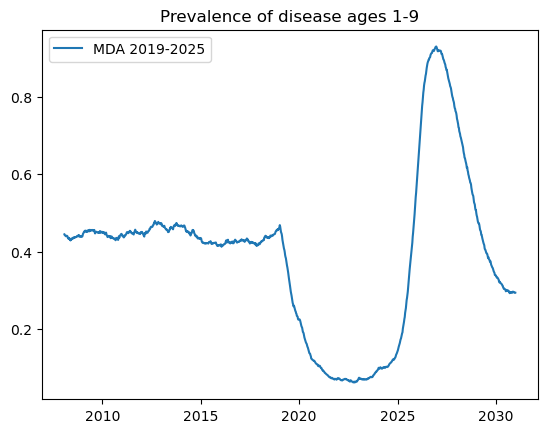

In [38]:
import matplotlib.pyplot as plt
start_year = 2010-burnin/52 # was 2018 - check to match csv dates
plt.plot(start_year + np.array(res_no_interruption[0]['Time'][(sim_params['burnin']-100): sim_params['timesim']]),np.array(res_no_interruption[0]['Median_Disease_Children'][(sim_params['burnin']-100): sim_params['timesim']]))
plt.legend(['MDA 2019-2025']) 
plt.title("Prevalence of disease ages 1-9")

Text(0.5, 1.0, 'Prevalence of infection ages 1-9')

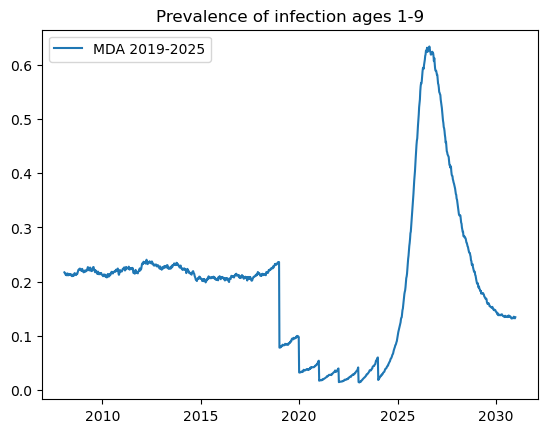

In [39]:
plt.plot(start_year + np.array(res_no_interruption[0]['Time'][(sim_params['burnin']-100): sim_params['timesim']]), np.array(res_no_interruption[0]['Median_Infection_Children'][(sim_params['burnin']-100): sim_params['timesim']]))
plt.legend(['MDA 2019-2025']) 
plt.title("Prevalence of infection ages 1-9")

## Disease prevalence by age

Text(0.5, 1.0, 'Prevalence of disease by age')

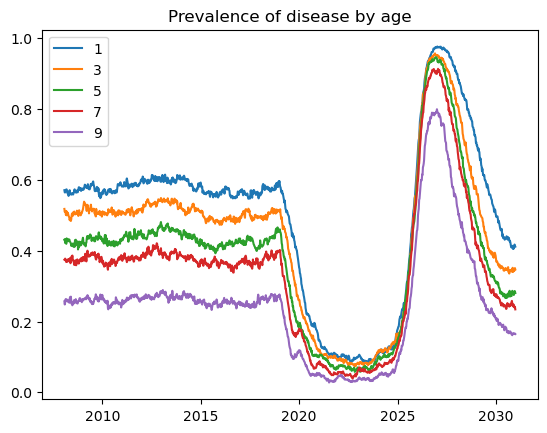

In [40]:
start_year = 2010-burnin/52 # was 2018 - check to match csv dates
ages = [1,3,5,7,9] # select which age groups from 0 to 9 to plot
for i in ages:
    plt.plot(start_year + np.array(res_no_interruption[0]['Time'][(sim_params['burnin']-100): sim_params['timesim']]),np.array(res_no_interruption[0]['Median_Dis_'+str(i)][(sim_params['burnin']-100): sim_params['timesim']]), label = str(i))


plt.legend() 
plt.title("Prevalence of disease by age")

## Infection prevalence by age

Text(0.5, 1.0, 'Prevalence of infection by age')

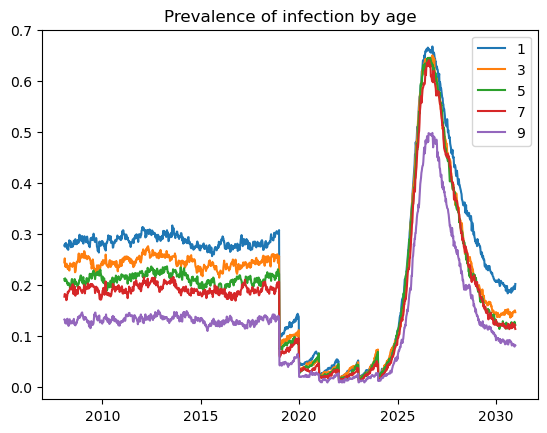

In [41]:
start_year = 2010-burnin/52 # was 2018 - check to match csv dates
ages = [1,3,5,7,9]
for i in ages:
    plt.plot(start_year + np.array(res_no_interruption[0]['Time'][(sim_params['burnin']-100): sim_params['timesim']]),np.array(res_no_interruption[0]['Median_Inf_'+str(i)][(sim_params['burnin']-100): sim_params['timesim']]), label = str(i))

plt.legend() 
plt.title("Prevalence of infection by age")

## Infection prevalence distribution plots (repeat for disease?)

In [42]:
# find MDA times, to know which weeks to plot
print(MDA_times)
data = res_no_interruption[0]

[5669 5721 5774 5826 5878 5930]


### Pre-MDA

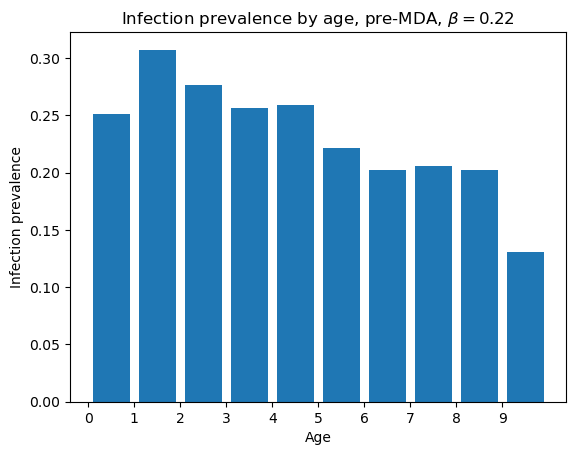

In [43]:
preinfs = [data['Median_Inf_' + str(i)][5667] for i in range(10)]

plt.bar([x+0.5 for x in range(10)], preinfs)
plt.xlabel('Age')
plt.ylabel('Infection prevalence')
plt.title(r'Infection prevalence by age, pre-MDA, $\beta=0.22$')
plt.xticks([i for i in range(10)]);

### After 3 years

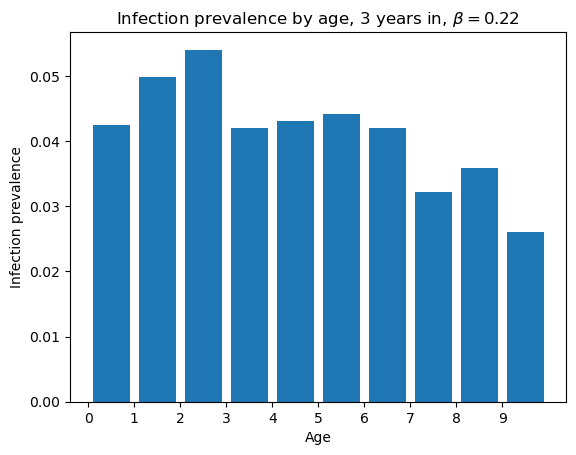

In [44]:
preinfs = [data['Median_Inf_' + str(i)][5824] for i in range(10)]
plt.bar([x+0.5 for x in range(10)], preinfs)
plt.xlabel('Age')
plt.ylabel('Infection prevalence')
plt.title(r'Infection prevalence by age, 3 years in, $\beta=0.22$')
plt.xticks([i for i in range(10)]);

### After 5 years

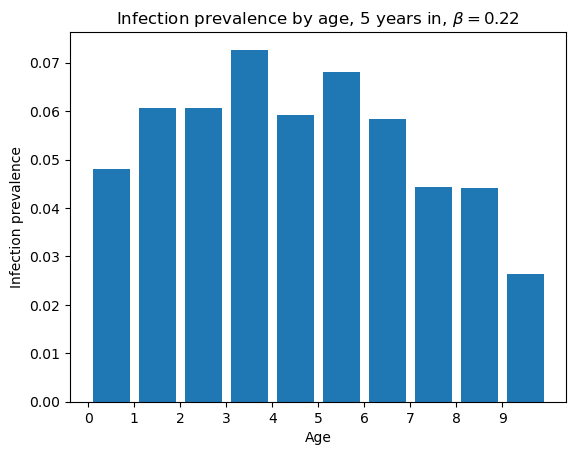

In [45]:
preinfs = [data['Median_Inf_' + str(i)][5928] for i in range(10)]
plt.bar([x+0.5 for x in range(10)], preinfs)
plt.xlabel('Age')
plt.ylabel('Infection prevalence')
plt.title(r'Infection prevalence by age, 5 years in, $\beta=0.22$')
plt.xticks([i for i in range(10)]);

### Post-MDA (3 years)

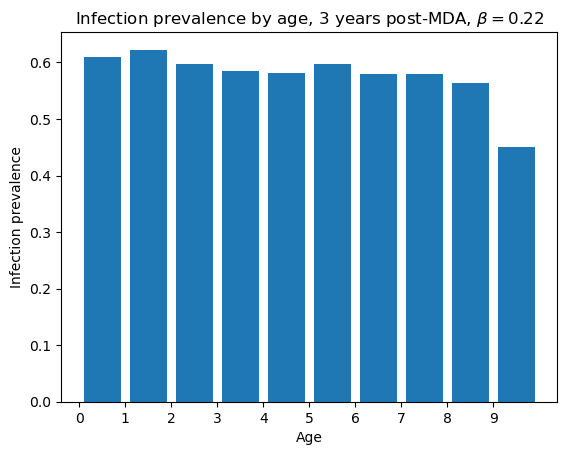

In [46]:
preinfs = [data['Median_Inf_' + str(i)][6085] for i in range(10)]
plt.bar([x+0.5 for x in range(10)], preinfs)
plt.xlabel('Age')
plt.ylabel('Infection prevalence')
plt.title(r'Infection prevalence by age, 3 years post-MDA, $\beta=0.22$')
plt.xticks([i for i in range(10)]);

## Distribution of infection counts by age

In [47]:
import seaborn as sns
import math
age_data = res_no_interruption[1]

### Pre-MDA

Text(0.5, 1.0, 'Infection distribution by age, pre-MDA, $\\beta=0.22$')

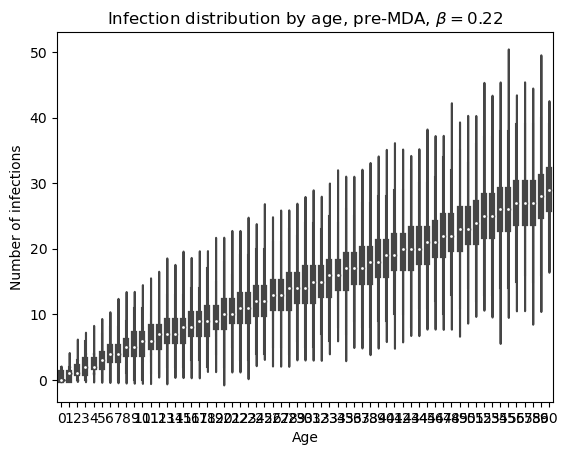

In [64]:
# Pick out week 5667
ages_5667, infs_5667 = age_data['ages5667'], age_data['inf_counts5667']
round_ages = np.array([math.floor(age/52) for age in ages_5667]) # converts ages to years
age_lim = np.where((round_ages >= 0) & (round_ages <= 60))[0] # specify lower and upper ages for plotting
infections_pre = pd.DataFrame({'Age': round_ages[age_lim], 'Number of infections': infs_5667[age_lim]})
sns.violinplot(infections_pre, x = "Age", y = "Number of infections").set_title(r"Infection distribution by age, pre-MDA, $\beta=0.22$")

### After 3 years

Text(0.5, 1.0, 'Infection distribution by age, 3 years in, $\\beta=0.22$')

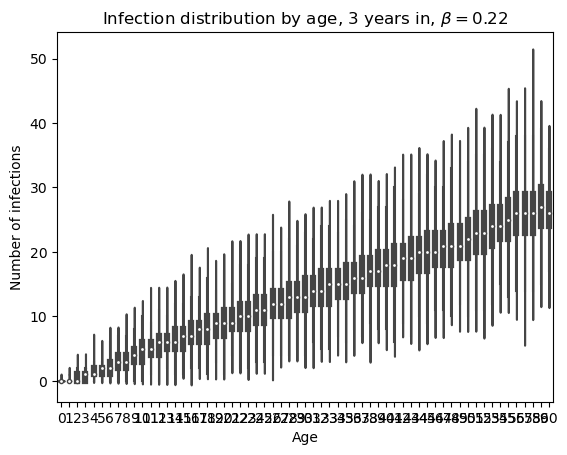

In [49]:
# Pick out week 5824
ages_5824, infs_5824 = age_data['ages5824'], age_data['inf_counts5824']
round_ages = np.array([math.floor(age/52) for age in ages_5824])
age_lim = np.where((round_ages >= 0) & (round_ages <= 60))[0]
infections_pre = pd.DataFrame({'Age': round_ages[age_lim], 'Number of infections': infs_5824[age_lim]})
sns.violinplot(infections_pre, x = "Age", y = "Number of infections").set_title(r"Infection distribution by age, 3 years in, $\beta=0.22$")

### After 5 years

Text(0.5, 1.0, 'Infection distribution by age, 5 years in, $\\beta=0.22$')

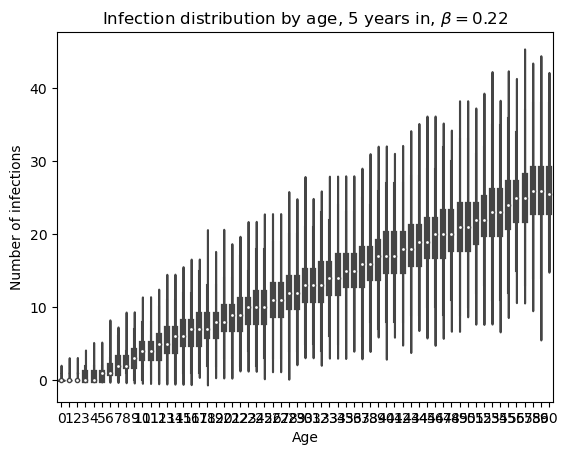

In [50]:
# Pick out week 5928
ages_5928, infs_5928 = age_data['ages5928'], age_data['inf_counts5928']
round_ages = np.array([math.floor(age/52) for age in ages_5928])
age_lim = np.where((round_ages >= 0) & (round_ages <= 60))[0]
infections_pre = pd.DataFrame({'Age': round_ages[age_lim], 'Number of infections': infs_5928[age_lim]})
sns.violinplot(infections_pre, x = "Age", y = "Number of infections").set_title(r"Infection distribution by age, 5 years in, $\beta=0.22$")

### Post-MDA (3 years)

Text(0.5, 1.0, 'Infection distribution by age, 3 years post-MDA, $\\beta=0.22$')

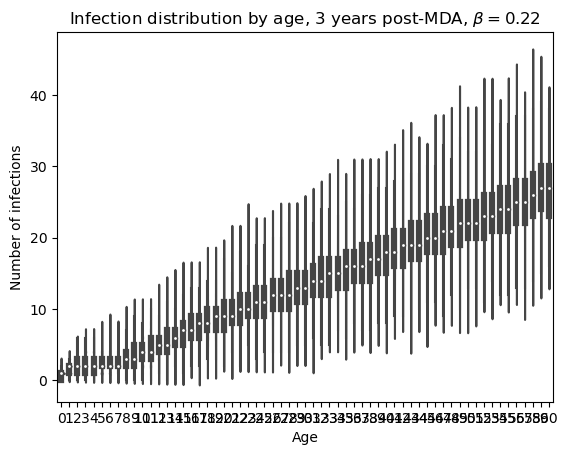

In [51]:
# Pick out week 6085
ages_6085, infs_6085 = age_data['ages6085'], age_data['inf_counts6085']
round_ages = np.array([math.floor(age/52) for age in ages_6085])
age_lim = np.where((round_ages >= 0) & (round_ages <= 60))[0]
infections_pre = pd.DataFrame({'Age': round_ages[age_lim], 'Number of infections': infs_6085[age_lim]})
sns.violinplot(infections_pre, x = "Age", y = "Number of infections").set_title(r"Infection distribution by age, 3 years post-MDA, $\beta=0.22$")

## Bacterial load and force of infection

In [52]:
import math
age_data = res_no_interruption[1]

### Pre-MDA

Text(0.5, 1.0, 'Bacterial load by age, pre-MDA, $\\beta=0.22$')

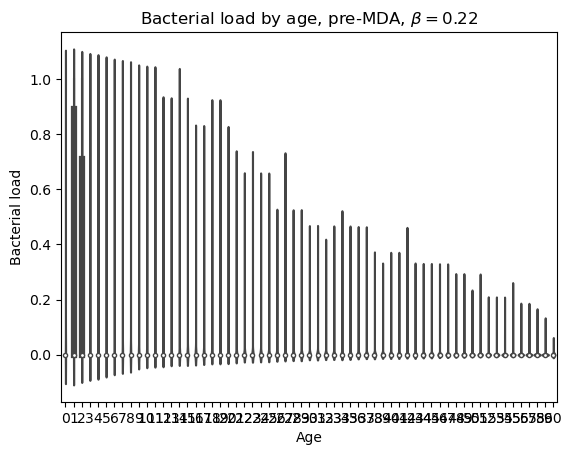

In [53]:
# Pick out week 5667
ages_5667, bact_5667 = age_data['ages5667'], age_data['bact5667']
round_ages = np.array([math.floor(age/52) for age in ages_5667])
age_lim = np.where((round_ages >= 0) & (round_ages <= 60))[0]
infections_pre = pd.DataFrame({'Age': round_ages[age_lim], 'Bacterial load': bact_5667[age_lim]})
sns.violinplot(infections_pre, x = "Age", y = "Bacterial load").set_title(r"Bacterial load by age, pre-MDA, $\beta=0.22$")

### After 3 years

Text(0.5, 1.0, 'Bacterial load by age, 3 years in, $\\beta=0.22$')

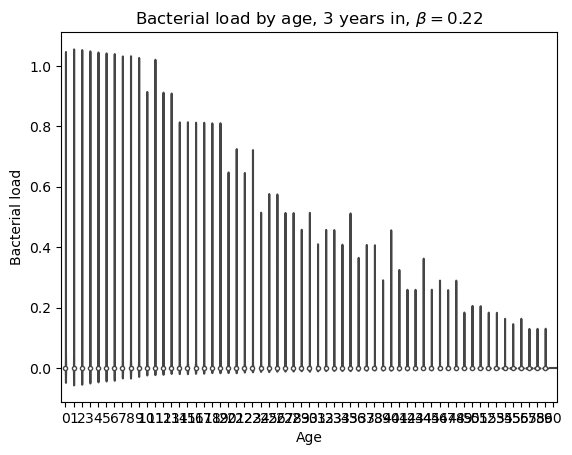

In [54]:
# Pick out week 5824
ages_5824, bact_5824 = age_data['ages5824'], age_data['bact5824']
round_ages = np.array([math.floor(age/52) for age in ages_5824])
age_lim = np.where((round_ages >= 0) & (round_ages <= 60))[0]
infections_pre = pd.DataFrame({'Age': round_ages[age_lim], 'Bacterial load': bact_5824[age_lim]})
sns.violinplot(infections_pre, x = "Age", y = "Bacterial load").set_title(r"Bacterial load by age, 3 years in, $\beta=0.22$")

### After 5 years

Text(0.5, 1.0, 'Bacterial load by age, 5 years in, $\\beta=0.22$')

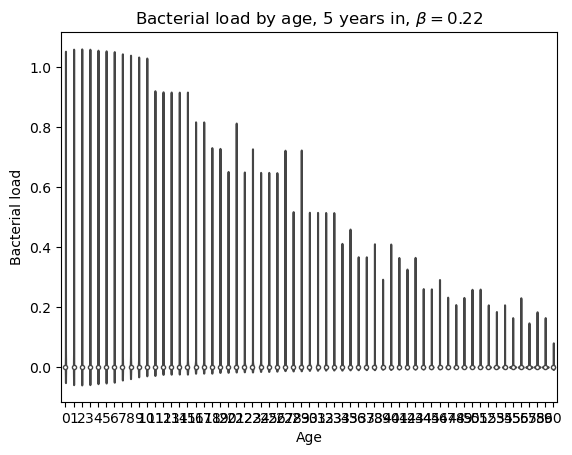

In [55]:
# Pick out week 5928
ages_5928, bact_5928 = age_data['ages5928'], age_data['bact5928']
round_ages = np.array([math.floor(age/52) for age in ages_5928])
age_lim = np.where((round_ages >= 0) & (round_ages <= 60))[0]
infections_pre = pd.DataFrame({'Age': round_ages[age_lim], 'Bacterial load': bact_5928[age_lim]})
sns.violinplot(infections_pre, x = "Age", y = "Bacterial load").set_title(r"Bacterial load by age, 5 years in, $\beta=0.22$")

### Post-MDA (3 years)

Text(0.5, 1.0, 'Bacterial load by age, 3 years post-MDA, $\\beta=0.22$')

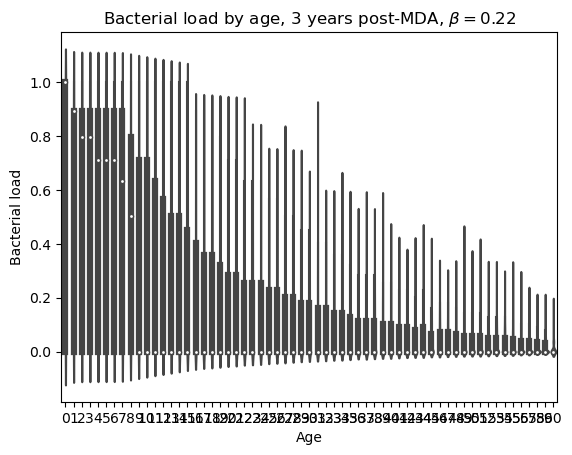

In [56]:
# Pick out week 6085
ages_6085, bact_6085 = age_data['ages6085'], age_data['bact6085']
round_ages = np.array([math.floor(age/52) for age in ages_6085])
age_lim = np.where((round_ages >= 0) & (round_ages <= 60))[0]
infections_pre = pd.DataFrame({'Age': round_ages[age_lim], 'Bacterial load': bact_6085[age_lim]})
sns.violinplot(infections_pre, x = "Age", y = "Bacterial load").set_title(r"Bacterial load by age, 3 years post-MDA, $\beta=0.22$")

### Lambda plots

(2015.0, 2030.0)

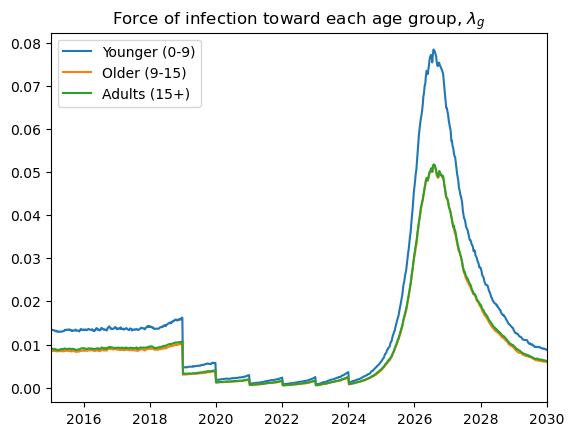

In [57]:
groups = ['Force_y', 'Force_o', 'Force_a'] # specify which groups to plot, currently including children (old/young) and adults
for g in groups:
    plt.plot(start_year + np.array(res_no_interruption[0]['Time'][(sim_params['burnin']-100): sim_params['timesim']]),np.array(res_no_interruption[0][g][(sim_params['burnin']-100): sim_params['timesim']]), label = g)


plt.legend(['Younger (0-9)', 'Older (9-15)', 'Adults (15+)']) 
plt.title(r"Force of infection toward each age group, $\lambda_g$")
plt.xlim([2015,2030])
#plt.ylim([0,0.01])

### New infections per group plot - shows where the new infections go

(2015.0, 2030.0)

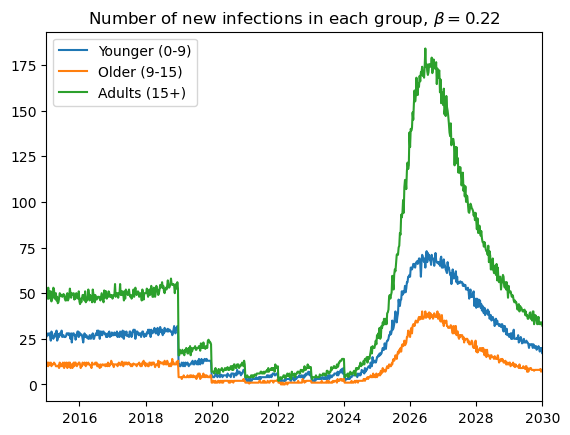

In [58]:
groups = ['New_Inf_y', 'New_Inf_o', 'New_Inf_a'] # specify which group(s) to plot
for g in groups:
    plt.plot(start_year + np.array(res_no_interruption[0]['Time'][(sim_params['burnin']-100): sim_params['timesim']]),np.array(res_no_interruption[0][g][(sim_params['burnin']-100): sim_params['timesim']]), label = g)


plt.legend(['Younger (0-9)', 'Older (9-15)', 'Adults (15+)']) 
plt.title(r"Number of new infections in each group, $\beta=0.22$")
plt.xlim([2015,2030])
#plt.ylim([0,100])

### Proportion of each group who's just become infected

Text(0.5, 1.0, 'Proportion of each group newly infected, $\\beta=0.22$')

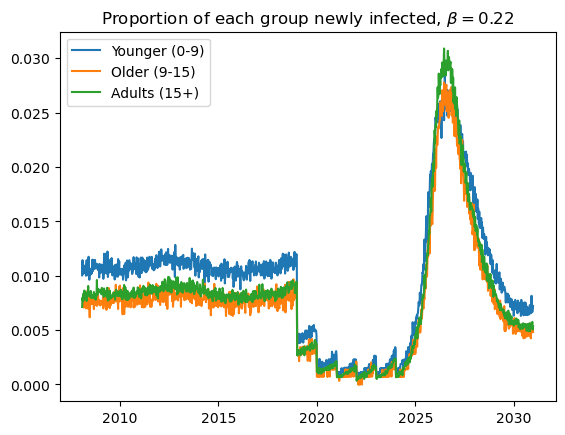

In [59]:
groups = ['New_Prop_y', 'New_Prop_o', 'New_Prop_a']
for g in groups:
    plt.plot(start_year + np.array(res_no_interruption[0]['Time'][(sim_params['burnin']-100): sim_params['timesim']]),np.array(res_no_interruption[0][g][(sim_params['burnin']-100): sim_params['timesim']]), label = g)


plt.legend(['Younger (0-9)', 'Older (9-15)', 'Adults (15+)']) 
plt.title(r"Proportion of each group newly infected, $\beta=0.22$")
#plt.xlim([2015,2030])
#plt.ylim([0,100])

### Function plots

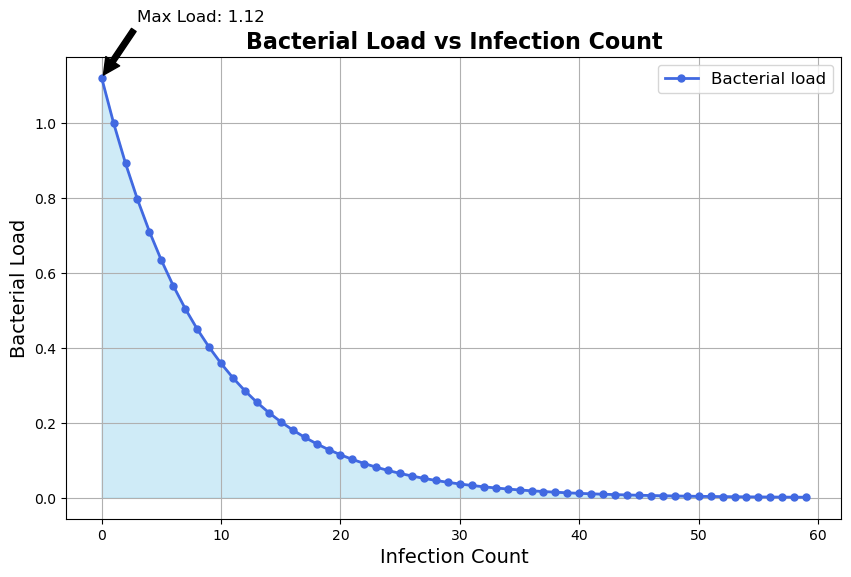

In [60]:
b1, ep2 = 1, 0.114
x = np.arange(60)
y = b1 * np.exp(-ep2 * (x - 1))

plt.figure(figsize=(10, 6))  # Larger figure for better visibility

plt.plot(x, y, color='royalblue', marker='o', linestyle='-', linewidth=2, markersize=5, label='Bacterial load')
plt.fill_between(x, y, color='skyblue', alpha=0.4)  # Add fill for better visual effect
plt.title('Bacterial Load vs Infection Count', fontsize=16, fontweight='bold')
plt.xlabel('Infection Count', fontsize=14)
plt.ylabel('Bacterial Load', fontsize=14)

# Adding annotations
max_index = np.argmax(y)
plt.annotate(f'Max Load: {y[max_index]:.2f}', 
             xy=(x[max_index], y[max_index]), 
             xytext=(x[max_index]+3, y[max_index]+0.15),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=12)

plt.legend(fontsize=12)
plt.grid(True)
plt.show()

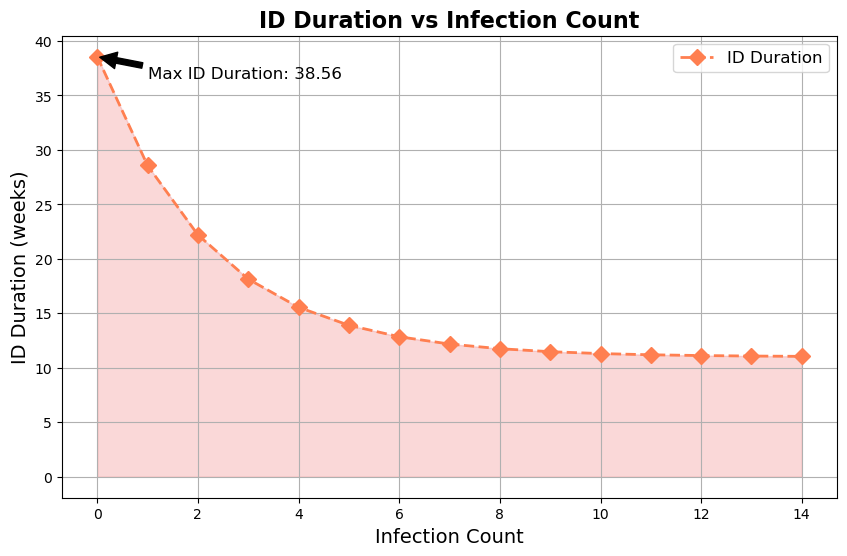

In [61]:
min_ID, Ind_ID_period_base, inf_red = 11, 200 / 7, 0.45
x1 = np.arange(15)
y1 = min_ID + (Ind_ID_period_base - min_ID) * np.exp(-inf_red * (x1 - 1))
plt.figure(figsize=(10, 6))  # Larger figure for better visibility
plt.plot(x1, y1, color='coral', marker='D', linestyle='--', linewidth=2, markersize=8, label='ID Duration')
plt.fill_between(x1, y1, color='lightcoral', alpha=0.3)  # Add fill for better visual effect
plt.title('ID Duration vs Infection Count', fontsize=16, fontweight='bold')
plt.xlabel('Infection Count', fontsize=14)
plt.ylabel('ID Duration (weeks)', fontsize=14)
# Adding annotations
max_index = np.argmax(y1)
plt.annotate(f'Max ID Duration: {y1[max_index]:.2f}', xy=(x1[max_index], y1[max_index]), 
             xytext=(x1[max_index]+1, y1[max_index]-2), arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12)
#plt.ylim([3,41])
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

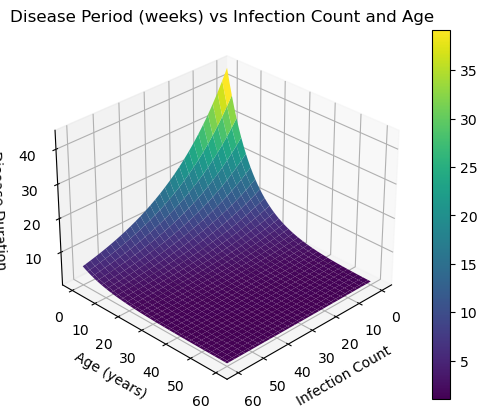

In [65]:
min_D, Ind_D_period_base, aq, ag = 1, 300/7, 0.0368, 0.00179
from mpl_toolkits.mplot3d import Axes3D
def z_function(x, y):
    return 1 + (300/7 - 1) * np.exp(-aq * (x - 1) - ag * 52 * y)
x = np.linspace(0, 60, 60)
y = np.linspace(0, 60, 60)
x, y = np.meshgrid(x, y)
z = z_function(x, y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surface = ax.plot_surface(x, y, z, cmap='viridis', edgecolor='none')

ax.set_xlabel('Infection Count')
ax.set_ylabel('Age (years)')
ax.set_zlabel('Disease Duration')
ax.set_title('Disease Period (weeks) vs Infection Count and Age')
ax.view_init(elev=30, azim=45)  # Elevation and azimuthal angles

plt.colorbar(surface)
plt.show()